# Length 7 and 10 CAZAC experiments

## Imports

In [2]:
import numpy as np
from tqdm import tqdm
import scipy.optimize as opt
import matplotlib.pyplot as plt

## Real system which defines CAZACs

In [3]:
def cazac_system(x):
    n = int(len(x)/2)
    a = x[:n]
    b = x[n:]
    F = np.zeros(3*n-2)
    F[:n] = a**2 + b**2 - 1
    for k in np.arange(1,n):
        F[n+k-1] = np.sum(a*np.roll(a,k)+b*np.roll(b,k))
        F[2*n-2+k] = np.sum(a*np.roll(b,k)-b*np.roll(a,k))
    return F

## Length 7 CAZAC Sequences
Number of length 7 CAZACs: 532<br>
Roots of unity CAZACs known: 42<br>
Non-roots of unity CAZACs known: Up to 252 (Bjorck)<br>

In [28]:
trials7 = 10000
rounding7 = 8
cost_factor7 = -10

In [29]:
opt_result = np.zeros((trials7,7),dtype='complex128')
opt_cost = np.zeros((trials7))
for trial in tqdm(np.arange(trials7)):
    x0 = np.random.rand((14))
    result = opt.least_squares(cazac_system,x0,jac='3-point',ftol=10**(-12),xtol=10**(-12),gtol=10**(-12))
    sequence = result.x[:7]+1j*result.x[7:]
    opt_result[trial,:] = sequence/sequence[0]
    opt_cost[trial] = result.cost

100%|█████████████████████████████████████| 10000/10000 [15:26<00:00, 10.80it/s]


In [61]:
cost_result = np.reshape(opt_result[np.where(opt_cost < 10**(cost_factor7)),:],(-1,7))
result_round = np.round(cost_result,decimals=rounding7)
result_unique = np.unique(result_round,axis=0)
np.savetxt('cazac_len7_result.csv',result_unique,fmt='%.8f')
np.savetxt('cazac_len7_cost.csv',opt_cost)
print('Maximum cost: %.6e'%np.max(opt_cost))
print('Sequences found: %d'%result_unique.shape[0])

Maximum cost: 9.917184e-25
Sequences found: 532


# Filtering out known length 7 CAZACs

In [4]:
cazac7 = np.genfromtxt('cazac_len7_result.csv',dtype=None)
T = np.zeros((7,7))
M = np.eye(7)*np.exp(2*np.pi*1j*np.arange(7)/7)
for j in np.arange(1,7):
    T[j,j-1]=1
T[0,6] = 1
D = np.zeros((6,7,7))
for m in np.arange(6):
    for j in np.arange(7):
        D[m,j,(m+1)*j%7] = 1

In [5]:
b = np.exp(1j*np.arccos(-3/4))
B = np.array([1,1,1,b,1,b,b])

In [6]:
Fcazac7 = np.zeros((532,7),dtype='complex')
Fcazac7[:,:] = cazac7[:,:]
for k in np.arange(7):
    for l in np.arange(7):
        for m in np.arange(6):
            matchMtx = np.linalg.matrix_power(M,l)@np.linalg.matrix_power(T,k)@D[m,:,:]@B
            matchMtx = matchMtx/matchMtx[0]
            rowmatch = np.where(np.sum(np.abs(cazac7 - matchMtx),axis=1) < 10**-5)
            rowmatch_conjugate = np.where(np.sum(np.abs(cazac7 - np.conjugate(matchMtx)),axis=1) < 10**-5)
            Fcazac7[rowmatch,:] = -10
            Fcazac7[rowmatch_conjugate,:] = -10
Fcazac7 = Fcazac7[np.where(Fcazac7[:,0] != -10)[0],:]
print(Fcazac7.shape)

(336, 7)


In [7]:
w = np.exp(2*np.pi*1j/7)
qp = np.array([1,w,w**3,w**6,w**10,w**15,w**21])

In [8]:
NewCazac7 = np.zeros((Fcazac7.shape[0],7), dtype ='complex')
NewCazac7[:,:] = Fcazac7[:,:]
for k in np.arange(7):
    for l in np.arange(7):
        for m in np.arange(6):
            matchMtx = np.linalg.matrix_power(M,l)@np.linalg.matrix_power(T,k)@D[m,:,:]@qp
            matchMtx = matchMtx/matchMtx[0]
            rowmatch = np.where(np.sum(np.abs(Fcazac7 - matchMtx),axis=1) < 10**-5)
            rowmatch_conjugate = np.where(np.sum(np.abs(Fcazac7 - np.conjugate(matchMtx)),axis=1) < 10**-5)
            NewCazac7[rowmatch,:] = -10
            NewCazac7[rowmatch_conjugate,:] = -10
NewCazac7 = NewCazac7[np.where(NewCazac7[:,0] != -10)[0],:]
np.savetxt('cazac_len7_result_new.csv',NewCazac7,fmt='%.8f')
print(NewCazac7.shape)

(294, 7)


# Aperiodic Simulation for length 7

In [1]:
def aperiodic_ambiguity(seq):
    n = len(seq)
    AF = np.zeros((2*n-1,n),dtype='complex')
    M = np.eye(n)*np.exp(2*np.pi*1j*np.arange(n)/n)
    
    # Negative time shift side
    for k in np.arange(1,n):
        for l in np.arange(n):
            translate_seq = np.zeros(n,dtype='complex')
            for j in np.arange(k,n):
                translate_seq[j] = seq[j-k]
            shift_seq = np.conjugate(np.linalg.matrix_power(M,l)@seq)
            AF[n-1-k,l] = np.dot(translate_seq,shift_seq)
    # Positive time shift side
    for k in np.arange(n):
        for l in np.arange(n):
            translate_seq = np.zeros(n,dtype='complex')
            for j in np.arange(n-k):
                translate_seq[j] = seq[j+k]
            shift_seq = np.conjugate(np.linalg.matrix_power(M,l)@seq)
            AF[n-1+k,l] = np.dot(translate_seq,shift_seq)
    return AF

def aperiodic_autocorrelation(seq):
    n = len(seq)
    AC = np.zeros(2*n-1,dtype='complex')
    
    # Negative time shift side
    for k in np.arange(1,n):
        translate_seq = np.zeros(n,dtype='complex')
        for j in np.arange(k,n):
            translate_seq[j] = seq[j-k]
        conj_seq = np.conjugate(seq)
        AC[n-1-k] = np.dot(conj_seq,translate_seq)
    # Positive time shift side
    for k in np.arange(n):
        translate_seq = np.zeros(n,dtype='complex')
        for j in np.arange(n-k):
            translate_seq[j] = seq[j+k]
        conj_seq = np.conjugate(seq)
        AC[n-1+k] = np.dot(conj_seq,translate_seq)
    return AC

In [22]:
chu = np.exp(np.pi*1j*np.arange(7)*(np.arange(7)-1)/7)
AC_chu = aperiodic_autocorrelation(chu)
AC_bjorck = aperiodic_autocorrelation(B)
AC_new = aperiodic_autocorrelation(NewCazac7[197,:])
print(NewCazac7[197,:])
psl_chu7 = np.max((np.abs(AF_chu[:6])/7,np.abs(AF_chu[7:]/7)))
psl_bjorck7 = np.max((np.abs(AF_bjorck[:6])/7,np.abs(AF_bjorck[7:]/7)))
psl_new7 = np.max((np.abs(AF_new[:6])/7,np.abs(AF_new[7:]/7)))

[ 1.        +0.j          0.53771613-0.84312595j  0.10887961-0.99405494j
  0.16381093+0.98649175j  0.94490392+0.32734781j -0.85028413+0.52632395j
  0.6234898 -0.78183148j]


197


In [34]:
new_opt = NewCazac7[197,:]
AF_chu = aperiodic_ambiguity(chu)
AF_newopt = aperiodic_ambiguity(new_opt)
AF_bjorck = aperiodic_ambiguity(B)

# Making pictures

0.41282969070020564


AttributeError: 'Axes3DSubplot' object has no attribute 'plot_meshgrid'

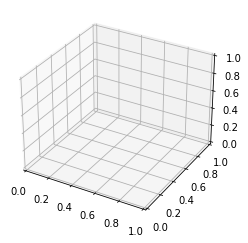

In [22]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(-3,3,7)
y = np.linspace(0,6,7)
X, Y = np.meshgrid(x,y)
#Z = np.ones((len(x),len(y)))
Z = np.abs(np.roll(AF_new,3,axis=0))/7
Z2 = np.abs(np.roll(AF_bjorck,3,axis=0))/7
print(Z[0,3])
#ax.plot_surface(X,Y,Z,cmap='binary')
ax.plot_meshgrid(Y,X,Z.T,cmap='binary',linewidth=0,antialiased=True)
ax.invert_xaxis()
ax.set_xlabel('Doppler shift')
ax.set_ylabel('Time shift')
ax.set_title('AF of a New CAZAC Sequence')
plt.savefig('new_cazac_psl.png')

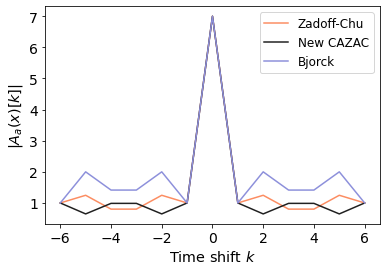

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(-6+np.arange(13),np.abs(AC_chu),c='#fc8d62',label='Zadoff-Chu')
ax.plot(-6+np.arange(13),np.abs(AC_new),c='#202020',label='New CAZAC')
ax.plot(-6+np.arange(13),np.abs(AC_bjorck),c='#8d90db',label='Bjorck')
ax.set_xlabel(r'Time shift $k$',size='x-large')
ax.set_ylabel(r'$|A_a(x)[k]|$',size='x-large')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 12})
plt.savefig('new_cazac_aac.png')

# Length 10 CAZACs

In [5]:
trials = 200000
rounding = 8
cost_factor = -10

In [6]:
opt_result = np.zeros((trials,10),dtype='complex128')
opt_cost = np.zeros((trials))
for trial in tqdm(np.arange(trials)):
    x0 = np.random.rand(20)
    result = opt.least_squares(cazac_system,x0,jac='3-point',ftol=10**(-12),xtol=10**(-12),gtol=10**(-12))
    sequence = result.x[:10]+1j*result.x[10:]
    opt_result[trial,:] = sequence/sequence[0]
    opt_cost[trial] = result.cost

100%|████████████████████████████████| 200000/200000 [12:41:08<00:00,  4.38it/s]


In [8]:
cost_result = np.reshape(opt_result[np.where(opt_cost < 10**(cost_factor)),:],(-1,10))
result_round = np.round(cost_result,decimals=rounding)
result_unique = np.unique(result_round,axis=0)
np.savetxt('cazac_len10_result_c128.csv',result_unique,fmt='%.8f')
np.savetxt('cazac_len10_cost_c128.csv',opt_cost)
print('Maximum cost: %.6e'%np.max(opt_cost))
print('Sequences found: %d'%result_unique.shape[0])

Maximum cost: 1.473457e-24
Sequences found: 3040


# AAC Length 10

In [44]:
cazac10 = np.genfromtxt('cazac_len10_result_c128.csv',dtype=None)

In [45]:
cazac10_psl = []
for i in np.arange(3040):
    AC = aperiodic_autocorrelation(cazac10[i,:])
    cazac10_psl.append(np.max((np.abs(AC[:9]),np.abs(AC[10:])))/10)

In [58]:
np.angle(cazac10[0,:])*10/(2*np.pi)

array([-0.        , -4.99366353,  1.96022662, -0.62790717, -0.32422719,
        1.01033914,  3.86689849, -4.52769744,  2.14210387,  3.64346076])

In [56]:
cazac10[0,:]
np.abs(aperiodic_autocorrelation(cazac10[0,:]))/10

array([0.1       , 0.09051921, 0.07970485, 0.15270597, 0.23309743,
       0.15270597, 0.07970486, 0.09051921, 0.1       , 1.        ,
       0.1       , 0.09051921, 0.07970486, 0.15270597, 0.23309743,
       0.15270597, 0.07970485, 0.09051921, 0.1       ])